## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

### <span style="color:darkred">Módulo 4 - Estratégias de Treinamento e Transferência de Aprendizado</span>

#### <span style="color:darkred">**Parte 1: Regularização (Dropout) e Normalização**</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from numpy.random import seed
from tensorflow.random import set_seed

tfds.disable_progress_bar()

2021-10-07 17:13:28.432254: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Carregando a base de dados "Cats vs Dogs"

Vamos ainda re-dimensionar as imagens para o tamanho $150\times 150$

Posteriormente, para aumentar a velocidade, vamos pré-calcular os batches

In [ ]:
(train_ds, validation_ds, test_ds), info = tfds.load(
    "cats_vs_dogs",
    split=["train[0%:20%]", "train[20%:25%]", "train[25%:40%]"],
    as_supervised=True,  # Include labels
    with_info=True
)

print(info)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

# redimensionando exemplos e normalizando entre 0-1 tipo float32
img_size = (150, 150)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
validation_ds = validation_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

input_shape = img_size+(3,)

2021-10-07 17:13:39.865686: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dataset cats_vs_dogs downloaded and prepared to /home/maponti/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


2021-10-07 17:15:01.234925: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-07 17:15:01.370071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 17:15:01.370748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 980M computeCapability: 5.2
coreClock: 1.1265GHz coreCount: 12 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 149.31GiB/s
2021-10-07 17:15:01.370820: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-10-07 17:15:01.400176: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-07 17:15:01.400375: I tensorflow/stream_executor/pl

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='/home/maponti/tensorflow_datasets/cats_vs_dogs/4.0.0',
    download_size=786.68 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},

In [ ]:
# definindo tamanho de batch e colocando os batches num "cache"
batch_size = 16
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

2021-10-07 17:15:06.313418: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-07 17:15:06.328305: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2594980000 Hz
2021-10-07 17:15:06.878205: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


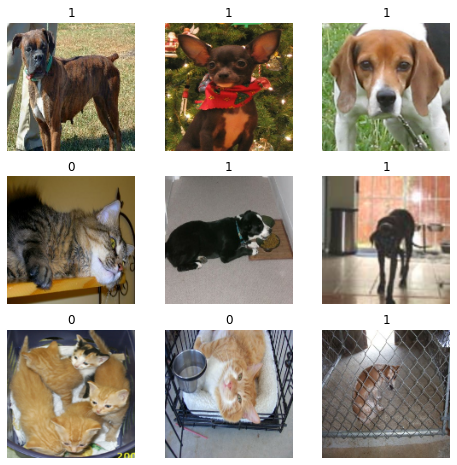

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(int(labels[i]))
        plt.axis("off")

### 1) Vamos investigar uma CNN sequencial, e adicionar opções de Dropout (regularização), e normalização por batch e por camada

In [ ]:
def my_cnn(input_shape, num_classes, dropout_rate=0.0, batch_norm=False, layer_norm=False):
    
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    
    if (batch_norm): x = layers.BatchNormalization()(x)
    elif (layer_norm): x = layers.LayerNormalization()(x)
    x = layers.Activation("relu")(x)

    # guarda ativacao para somar ao fim do bloco residual
    ativacao_residual = x 

    for n_filtros in [64,64]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(n_filtros, 3, padding="same")(x)
        if (batch_norm): x = layers.BatchNormalization()(x)
        elif (layer_norm): x = layers.LayerNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(n_filtros, 3, padding="same")(x)
        if (batch_norm): x = layers.BatchNormalization()(x)
        elif (layer_norm): x = layers.LayerNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # residual
        residual = layers.Conv2D(n_filtros, 1, strides=2, padding="same")(
            ativacao_residual
        )
        x = layers.add([x, residual])  # adiciona resisual
        ativacao_residual = x  # armazena saida do bloco

    x = layers.SeparableConv2D(512, 3, padding="same")(x)
    if (batch_norm): x = layers.BatchNormalization()(x)
    elif (layer_norm): x = layers.LayerNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        neuronios = 1
    else:
        activation = "softmax"
        neuronios = num_classes

    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(neuronios, activation=activation)(x)

    return keras.Model(inputs, outputs)

### I - Avaliando o papel da Normalização

In [ ]:
seed(1)
set_seed(2)

epochs = 6

CNN1 = my_cnn(input_shape=input_shape, num_classes=2, dropout_rate=0.0, batch_norm=False, layer_norm=False)
CNN1.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              metrics=['accuracy'])

hist1 = CNN1.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=validation_ds)

Epoch 1/8


2021-10-07 17:15:09.887188: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-10-07 17:15:10.641509: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8200
2021-10-07 17:15:11.751030: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-07 17:15:12.527927: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


175/291 [=================>............] - ETA: 9s - loss: 0.6937 - accuracy: 0.4871

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


291/291 [==============================] - 31s 91ms/step - loss: 0.6940 - accuracy: 0.4929 - val_loss: 0.6926 - val_accuracy: 0.5095
Epoch 2/8
291/291 [==============================] - 25s 86ms/step - loss: 0.6935 - accuracy: 0.5064 - val_loss: 0.6922 - val_accuracy: 0.5155
Epoch 3/8
291/291 [==============================] - 27s 91ms/step - loss: 0.6931 - accuracy: 0.5138 - val_loss: 0.6917 - val_accuracy: 0.5223
Epoch 4/8
291/291 [==============================] - 30s 104ms/step - loss: 0.6925 - accuracy: 0.5224 - val_loss: 0.6910 - val_accuracy: 0.5326
Epoch 5/8
291/291 [==============================] - 29s 100ms/step - loss: 0.6918 - accuracy: 0.5271 - val_loss: 0.6901 - val_accuracy: 0.5438
Epoch 6/8
291/291 [==============================] - 29s 100ms/step - loss: 0.6909 - accuracy: 0.5314 - val_loss: 0.6889 - val_accuracy: 0.5541
Epoch 7/8
291/291 [==============================] - 30s 103ms/step - loss: 0.6896 - accuracy: 0.5415 - val_loss: 0.6873 - val_accuracy: 0.5584
Epoch

### com Batch Normalization

In [ ]:
seed(1)
set_seed(2)

CNN2 = my_cnn(input_shape=input_shape, num_classes=2, dropout_rate=0.0, batch_norm=True, layer_norm=False)

CNN2.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              metrics=['accuracy'])

hist2 = CNN2.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=validation_ds)

/home/maponti/.virtualenvs/rn21/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/8
291/291 [==============================] - 31s 103ms/step - loss: 0.6740 - accuracy: 0.5907 - val_loss: 0.7478 - val_accuracy: 0.4905
Epoch 2/8
291/291 [==============================] - 33s 115ms/step - loss: 0.6380 - accuracy: 0.6339 - val_loss: 0.6278 - val_accuracy: 0.6564
Epoch 3/8
291/291 [==============================] - 35s 121ms/step - loss: 0.6151 - accuracy: 0.6642 - val_loss: 0.6191 - val_accuracy: 0.6770
Epoch 4/8
291/291 [==============================] - 35s 121ms/step - loss: 0.5934 - accuracy: 0.6855 - val_loss: 1.0008 - val_accuracy: 0.5782
Epoch 5/8
291/291 [==============================] - 36s 123ms/step - loss: 0.5740 - accuracy: 0.6945 - val_loss: 0.6319 - val_accuracy: 0.6684
Epoch 6/8
291/291 [==============================] - 35s 122ms/step - loss: 0.5554 - accuracy: 0.7117 - val_loss: 0.6262 - val_accuracy: 0.6830
Epoch 7/8
291/291 [==============================] - 35s 119ms/step - loss: 0.5345 - accuracy: 0.7315 - val_loss: 0.5701 - val_accuracy:

### com Layer Normalization

In [ ]:
seed(1)
set_seed(2)

CNN3 = my_cnn(input_shape=input_shape, num_classes=2, dropout_rate=0.0, batch_norm=False, layer_norm=True)

CNN3.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              metrics=['accuracy'])

hist3 = CNN3.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=validation_ds)

Epoch 1/8
291/291 [==============================] - 52s 174ms/step - loss: 0.7572 - accuracy: 0.4936 - val_loss: 0.6843 - val_accuracy: 0.5541
Epoch 2/8
291/291 [==============================] - 60s 205ms/step - loss: 0.7221 - accuracy: 0.5226 - val_loss: 0.6890 - val_accuracy: 0.5601
Epoch 3/8
291/291 [==============================] - 67s 230ms/step - loss: 0.7027 - accuracy: 0.5112 - val_loss: 0.6869 - val_accuracy: 0.5593
Epoch 4/8
291/291 [==============================] - 67s 231ms/step - loss: 0.6973 - accuracy: 0.5305 - val_loss: 0.6877 - val_accuracy: 0.5593
Epoch 5/8
291/291 [==============================] - 71s 245ms/step - loss: 0.6949 - accuracy: 0.5361 - val_loss: 0.6843 - val_accuracy: 0.5601
Epoch 6/8
291/291 [==============================] - 69s 238ms/step - loss: 0.6931 - accuracy: 0.5393 - val_loss: 0.6816 - val_accuracy: 0.5756
Epoch 7/8
291/291 [==============================] - 68s 235ms/step - loss: 0.6924 - accuracy: 0.5355 - val_loss: 0.6847 - val_accuracy:

com BN + Regularização Dropout

In [ ]:
seed(1)
set_seed(2)

CNN4 = my_cnn(input_shape=input_shape, num_classes=2, dropout_rate=0.25, batch_norm=True)

CNN4.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              metrics=['accuracy'])

hist4 = CNN4.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=validation_ds)

Epoch 1/8
291/291 [==============================] - 39s 129ms/step - loss: 0.6944 - accuracy: 0.5722 - val_loss: 0.7520 - val_accuracy: 0.4905
Epoch 2/8
291/291 [==============================] - 36s 123ms/step - loss: 0.6556 - accuracy: 0.6135 - val_loss: 0.6548 - val_accuracy: 0.6495
Epoch 3/8
291/291 [==============================] - 35s 120ms/step - loss: 0.6355 - accuracy: 0.6339 - val_loss: 0.6386 - val_accuracy: 0.6521
Epoch 4/8
142/291 [=============>................] - ETA: 17s - loss: 0.6293 - accuracy: 0.6435

KeyboardInterrupt: 

In [ ]:
scores1 = CNN1.evaluate(validation_ds, verbose=0)
scores2 = CNN2.evaluate(validation_ds, verbose=0)
scores3 = CNN3.evaluate(validation_ds, verbose=0)
scores4 = CNN4.evaluate(validation_ds, verbose=0)

In [ ]:
print("Na validação")
print("BatchNorm LayerNorm Dropout - Loss\tAcc")
print("    -         -        -      %.4f\t%.4f" % (scores1[0],scores1[1]))
print("    X         -        -      %.4f\t%.4f" % (scores2[0],scores2[1]))
print("    -         X        -      %.4f\t%.4f" % (scores3[0],scores3[1]))
print("    X         -        X      %.4f\t%.4f" % (scores4[0],scores4[1]))

**Resumo: avaliando os modelos**

In [ ]:
scores1 = CNN1.evaluate(test_ds, verbose=0)
scores2 = CNN2.evaluate(test_ds, verbose=0)
scores3 = CNN3.evaluate(test_ds, verbose=0)
scores4 = CNN4.evaluate(test_ds, verbose=0)

In [ ]:
print("BatchNorm LayerNorm Dropout - Loss\tAcc")
print("    -         -        -      %.4f\t%.4f" % (scores1[0],scores1[1]))
print("    X         -        -      %.4f\t%.4f" % (scores2[0],scores2[1]))
print("    -         X        -      %.4f\t%.4f" % (scores3[0],scores3[1]))
print("    X         -        X      %.4f\t%.4f" % (scores4[0],scores4[1]))

BatchNorm LayerNorm Dropout - Loss	Acc
    -         -        -      0.6924	0.5045
    X         -        -      0.6801	0.6402
    -         X        -      0.6295	0.6307
    X         -        X      0.5360	0.7309
